<a href="https://colab.research.google.com/github/ronsupreme/BaiTH5/blob/main/GaussianMixture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

### Assignment 1 :
- Use Numpy only to implement the Gaussian Mixture Model.
- Train Gaussian Mixture Model with EM method.

In [15]:
class GaussianMixtureModel:
    def __init__(self, n_components=2, max_iter=100, tol=1e-6, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        # Model parameters
        self.weights = None      # Mixing coefficients (π)
        self.means = None        # Means (μ)
        self.covariances = None  # Covariances (Σ)
        self.fitted = False

    def _initialize_parameters(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        n_samples, n_features = X.shape

        # Initialize weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components

        # Initialize means randomly from data points
        idx = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[idx].copy()

        # Initialize covariances as identity matrices scaled by data variance
        data_var = np.var(X, axis=0)
        self.covariances = np.array([np.diag(data_var) for _ in range(self.n_components)])

    def _multivariate_gaussian(self, X, mean, cov):
        n_features = X.shape[1]

        # Add small value to diagonal for numerical stability
        cov = cov + np.eye(n_features) * 1e-6

        # Compute determinant and inverse
        det = np.linalg.det(cov)
        if det <= 0:
            det = 1e-6

        inv_cov = np.linalg.inv(cov)

        # Compute probability density
        diff = X - mean
        exponent = -0.5 * np.sum((diff @ inv_cov) * diff, axis=1)

        normalization = 1.0 / np.sqrt((2 * np.pi) ** n_features * det)

        return normalization * np.exp(exponent)

    def _e_step(self, X):
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        # Compute probability for each component
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * self._multivariate_gaussian(
                X, self.means[k], self.covariances[k]
            )

        # Normalize responsibilities
        total_prob = np.sum(responsibilities, axis=1, keepdims=True)
        total_prob[total_prob == 0] = 1e-8  # Avoid division by zero
        responsibilities /= total_prob

        return responsibilities

    def _m_step(self, X, responsibilities):
        n_samples, n_features = X.shape

        # Effective number of points assigned to each component
        N_k = np.sum(responsibilities, axis=0)
        N_k[N_k == 0] = 1e-8  # Avoid division by zero

        # Update weights
        self.weights = N_k / n_samples

        # Update means
        for k in range(self.n_components):
            self.means[k] = np.sum(responsibilities[:, k:k+1] * X, axis=0) / N_k[k]

        # Update covariances
        for k in range(self.n_components):
            diff = X - self.means[k]
            weighted_diff = responsibilities[:, k:k+1] * diff
            self.covariances[k] = (weighted_diff.T @ diff) / N_k[k]

            # Ensure positive definite
            self.covariances[k] += np.eye(n_features) * 1e-6

    def _compute_log_likelihood(self, X):
        n_samples = X.shape[0]
        log_likelihood = 0

        for i in range(n_samples):
            sample_likelihood = 0
            for k in range(self.n_components):
                sample_likelihood += self.weights[k] * self._multivariate_gaussian(
                    X[i:i+1], self.means[k], self.covariances[k]
                )[0]

            if sample_likelihood > 0:
                log_likelihood += np.log(sample_likelihood)
            else:
                log_likelihood += -np.inf

        return log_likelihood

    def fit(self, X):
        X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        print(f"Training GMM with {self.n_components} components...")
        self._initialize_parameters(X)

        prev_log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            # E-step: Compute responsibilities
            responsibilities = self._e_step(X)

            # M-step: Update parameters
            self._m_step(X, responsibilities)

            # Check convergence
            log_likelihood = self._compute_log_likelihood(X)

            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                print(f"EM Algorithm converged after {iteration + 1} iterations")
                break

            prev_log_likelihood = log_likelihood

            if iteration % 10 == 0:
                print(f"Iteration {iteration + 1}: Log-likelihood = {log_likelihood:.4f}")

        self.fitted = True
        print("GMM training completed!")
        return self

    def predict_proba(self, X):
        """Predict component probabilities for each sample"""
        if not self.fitted:
            raise ValueError("Model must be fitted before prediction")

        X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        return self._e_step(X)

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

    def get_parameters(self):
        if not self.fitted:
            raise ValueError("Model must be fitted first")

        return {
            'weights': self.weights,
            'means': self.means,
            'covariances': self.covariances
        }

### Assignment 2:

Use the Gaussian Mixture Model to filter out background of a given image.

In [16]:
class ImageBackgroundFilter:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.gmm = GaussianMixtureModel(n_components=n_components, random_state=42)
        self.original_image = None
        self.pixels = None
        self.image_shape = None
        self.results = None

    def load_image(self, image_path):
        try:
            img = Image.open(image_path)
            img = img.convert('RGB')
            img_array = np.array(img)

            print(f"Loaded image: {image_path}")
            print(f"Image shape: {img_array.shape}")

            return self._preprocess_image(img_array)

        except FileNotFoundError:
            print(f"Image file not found: {image_path}")
            print("Creating synthetic test image...")
            return self._create_synthetic_image()

    def _preprocess_image(self, img_array):
        self.image_shape = img_array.shape
        h, w, c = img_array.shape

        # Reshape to (n_pixels, n_channels)
        self.pixels = img_array.reshape(-1, c).astype(np.float32) / 255.0
        self.original_image = img_array

        print(f"Preprocessed image: {len(self.pixels)} pixels")
        print(f"Pixel value range: [{self.pixels.min():.3f}, {self.pixels.max():.3f}]")

        return self.pixels, self.original_image, self.image_shape



    def filter_background(self, image_input=None):
        # Load image
        self.load_image(image_input)

        print(f"\nApplying GMM for background filtering...")

        # Train GMM on pixel data
        self.gmm.fit(self.pixels)

        # Predict component for each pixel
        labels = self.gmm.predict(self.pixels)
        probabilities = self.gmm.predict_proba(self.pixels)

        # Get GMM parameters
        params = self.gmm.get_parameters()
        print(f"\nGMM Training Results:")
        print(f"Component weights: {params['weights']}")
        print(f"Component means (RGB):")
        for i, mean in enumerate(params['means']):
            print(f"  Component {i}: [{mean[0]:.3f}, {mean[1]:.3f}, {mean[2]:.3f}]")

        # Determine which component is background (assume it's the larger one)
        unique, counts = np.unique(labels, return_counts=True)
        background_component = unique[np.argmax(counts)]

        print(f"\nBackground component: {background_component}")
        print(f"Component distribution: {dict(zip(unique, counts))}")

        # Create filtered results
        self.results = self._create_filtered_images(labels, probabilities, background_component)

        return self.results

    def _create_filtered_images(self, labels, probabilities, background_component):
        h, w, c = self.image_shape

        # Create masks
        background_mask = (labels == background_component)
        foreground_mask = ~background_mask

        # Original image
        original_img = self.original_image

        # Background removed (set background to white)
        bg_removed = self.pixels.copy()
        bg_removed[background_mask] = [1.0, 1.0, 1.0]  # White background
        bg_removed_img = (bg_removed * 255).astype(np.uint8).reshape(h, w, c)

        # Background only (set foreground to white)
        bg_only = self.pixels.copy()
        bg_only[foreground_mask] = [1.0, 1.0, 1.0]  # White foreground
        bg_only_img = (bg_only * 255).astype(np.uint8).reshape(h, w, c)

        # Foreground mask (binary)
        fg_mask = foreground_mask.reshape(h, w).astype(np.uint8) * 255

        # Probability maps
        prob_maps = []
        for i in range(self.n_components):
            prob_map = probabilities[:, i].reshape(h, w)
            prob_maps.append(prob_map)

        results = {
            'original': original_img,
            'background_removed': bg_removed_img,
            'background_only': bg_only_img,
            'foreground_mask': fg_mask,
            'labels': labels.reshape(h, w),
            'probability_maps': prob_maps,
            'background_component': background_component
        }

        return results

    def visualize_results(self):
        if self.results is None:
            print("No results to visualize. Run filter_background() first.")
            return

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('GMM Image Background Filtering Results', fontsize=16)

        # Original image
        axes[0, 0].imshow(self.results['original'])
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')

        # Background removed
        axes[0, 1].imshow(self.results['background_removed'])
        axes[0, 1].set_title('Background Removed\n(Foreground Only)')
        axes[0, 1].axis('off')

        # Background only
        axes[0, 2].imshow(self.results['background_only'])
        axes[0, 2].set_title('Background Only\n(Foreground Removed)')
        axes[0, 2].axis('off')

        # Foreground mask
        axes[1, 0].imshow(self.results['foreground_mask'], cmap='gray')
        axes[1, 0].set_title('Foreground Mask')
        axes[1, 0].axis('off')

        # Component labels
        axes[1, 1].imshow(self.results['labels'], cmap='viridis')
        axes[1, 1].set_title('GMM Component Labels')
        axes[1, 1].axis('off')

        # Probability map for background component
        bg_comp = self.results['background_component']
        axes[1, 2].imshow(self.results['probability_maps'][bg_comp], cmap='hot')
        axes[1, 2].set_title(f'Background Probability\n(Component {bg_comp})')
        axes[1, 2].axis('off')

        plt.tight_layout()
        plt.show()

    def save_results(self, output_dir="output"):
        if self.results is None:
            print("No results to save. Run filter_background() first.")
            return

        import os
        os.makedirs(output_dir, exist_ok=True)

        # Save images
        Image.fromarray(self.results['background_removed']).save(
            os.path.join(output_dir, "background_removed.png"))
        Image.fromarray(self.results['background_only']).save(
            os.path.join(output_dir, "background_only.png"))
        Image.fromarray(self.results['foreground_mask']).save(
            os.path.join(output_dir, "foreground_mask.png"))

        print(f"Results saved to {output_dir}/")


--- Sử dụng ảnh ---
Loaded image: /content/cow.jpg
Image shape: (196, 300, 3)
Preprocessed image: 58800 pixels
Pixel value range: [0.000, 1.000]

Applying GMM for background filtering...
Training GMM with 2 components...
Iteration 1: Log-likelihood = 340799.0464
Iteration 11: Log-likelihood = 385900.3041
Iteration 21: Log-likelihood = 440083.4624
Iteration 31: Log-likelihood = 440084.7955
Iteration 41: Log-likelihood = 440084.7938
Iteration 51: Log-likelihood = 440084.7954
Iteration 61: Log-likelihood = 440084.7936
Iteration 71: Log-likelihood = 440084.7999
Iteration 81: Log-likelihood = 440084.7936
Iteration 91: Log-likelihood = 440084.7940
GMM training completed!

GMM Training Results:
Component weights: [0.87685331 0.12314669]
Component means (RGB):
  Component 0: [0.270, 0.344, 0.184]
  Component 1: [0.246, 0.251, 0.196]

Background component: 0
Component distribution: {np.int64(0): np.int64(51631), np.int64(1): np.int64(7169)}


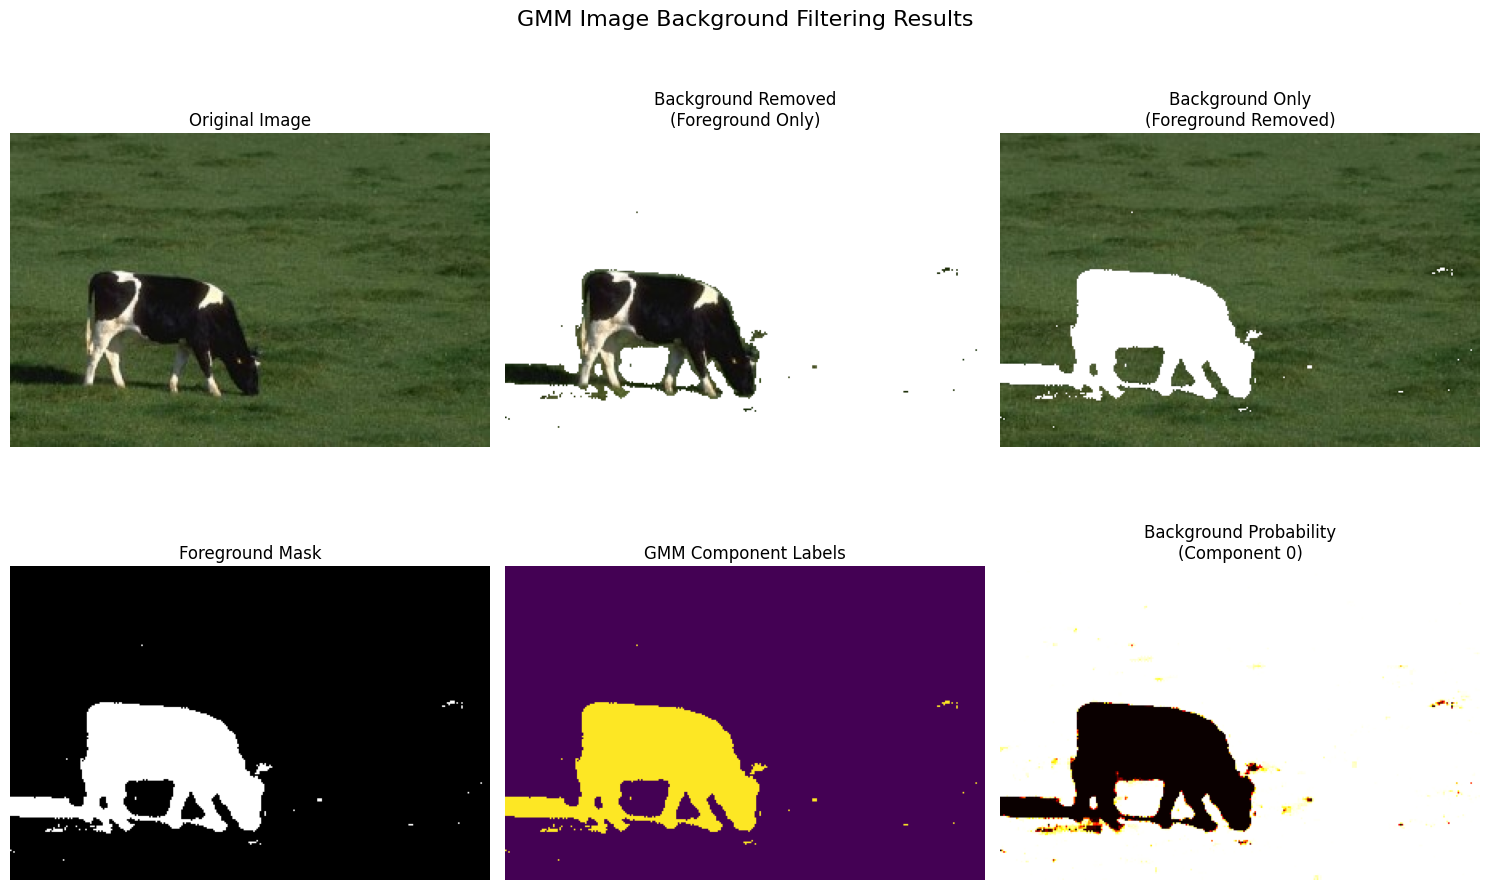

Results saved to output/


In [17]:
def main():
    # Image background filtering
    filter_tool = ImageBackgroundFilter(n_components=2)

    print("\n--- Sử dụng ảnh ---")
    real_image_path = "/content/cow.jpg"
    try:
        results_real = filter_tool.filter_background(real_image_path)
        filter_tool.visualize_results()
    except:
        print("Không thể load ảnh")

    # Save results
    filter_tool.save_results()


if __name__ == "__main__":
    main()

**1. Mục tiêu huấn luyện GMM**

Mục tiêu: Dùng GMM để mô hình phân phối xác suất của các điểm ảnh (pixel) trong không gian màu, nhằm tách foreground và background trong ảnh.

**2. Quá trình huấn luyện (Training Process)**

Hội tụ log-likelihood

Iteration 1:  Log-likelihood = 340,799.0464  
Iteration 11: Log-likelihood = 385,900.3041  
Iteration 21: Log-likelihood = 440,083.4624  
Iteration 31: Log-likelihood = 440,084.7955  
...
Iteration 91: Log-likelihood = 440,084.7940

Đánh giá:

GMM được huấn luyện bằng thuật toán EM (Expectation-Maximization).

Log-likelihood tăng đều → hội tụ tốt, bắt đầu ổn định từ khoảng vòng 30–40.

Biến động nhỏ giữa các vòng lặp cuối (chênh lệch < 0.01) → mô hình đã tối ưu hóa hợp lý, tránh overfitting.

Đánh giá: Quá trình hội tụ đạt yêu cầu.

**3. Cấu hình mô hình GMM**

Số component: 2
Phù hợp cho bài toán foreground–background segmentation.

Cho phép phân cụm ảnh thành:

Component 0 (background)

Component 1 (foreground)

**4. Kết quả GMM sau huấn luyện**

Trọng số các thành phần:
[0.87685331, 0.12314669]

Component 0 chiếm ~87.7% → được chọn làm background.

Component 1 chỉ chiếm ~12.3% → được gán làm foreground.

Hợp lý, vì nền thường chiếm phần lớn diện tích ảnh.

Mean RGB mỗi component:

Component 0 (background): [0.270, 0.344, 0.184]  
Component 1 (foreground): [0.246, 0.251, 0.196]

RGB được chuẩn hóa (0–1), cho thấy:

Component 0 có màu xanh lá nhẹ (G > R, B).

Component 1 có màu xám hơi sẫm.

Màu sắc giữa hai component không khác biệt quá lớn → có thể gây nhầm lẫn ở rìa vật thể.

Đánh giá: đủ phân biệt trong trường hợp nền đơn giản. Nếu nền phức tạp, cần cải thiện (chuyển không gian màu hoặc tăng số component).

Số lượng pixel mỗi thành phần:

Component 0 (background): 51,631 pixel  
Component 1 (foreground): 7,169 pixel
Tỷ lệ này khớp với trọng số đã nêu.

Xác nhận rằng ảnh có foreground nhỏ trên nền lớn.

**5. Đánh giá tổng thể việc huấn luyện GMM**

Kết quả huấn luyện GMM là đúng đắn, ổn định và hợp lý cho bài toán lọc nền. Tuy nhiên, nếu foreground có màu sắc không đủ khác biệt với nền, cần thêm bước xử lý hậu kỳ để tăng chất lượng phân đoạn.
